Non-negative Poisson Loss Reconstruction (APGM w/ adaptive PGMStepSize)
=======================================================================

This example demonstrates the use of class
[pgm.PGMStepSize](../_autosummary/scico.optimize.pgm.rst#scico.optimize.pgm.PGMStepSize)
to solve the non-negative reconstruction problem with Poisson negative
log likelihood loss

  $$\mathrm{argmin}_{\mathbf{x}} \; \frac{1}{2} \left ( A \mathbf{x} -
  \mathbf{y} \log\left( A \mathbf{x} \right) + \log(\mathbf{y}!) \right
  ) + I(\mathbf{x} \geq 0)\;,$$

where $A$ is the forward operator, $\mathbf{y}$ is the measurement,
$\mathbf{x}$ is the signal reconstruction, and $I(\mathbf{x} \geq 0)$
is the non-negative indicator.

In [1]:
import jax

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, plot
from scico.optimize.pgm import (
    AcceleratedPGM,
    AdaptiveBBStepSize,
    BBStepSize,
    LineSearchStepSize,
    RobustLineSearchStepSize,
)
from scico.util import device_info
from scipy.linalg import dft
plot.config_notebook_plotting()

Construct a dictionary, a reference random reconstruction, and a test
measurement signal consisting of the synthesis of the reference
reconstruction.

In [2]:
m = 1024  # signal size
n = 8  # dictionary size

# Create dictionary with bump-like features.
D = ((snp.real(dft(m))[1 : n + 1, :m]) ** 12).T

x_gt, key = scico.random.uniform((n,), seed=12345)  # true coefficients

lam = D @ x_gt
y, key = scico.random.poisson(lam, shape=lam.shape, key=key)  # synthetic signal

x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU
y = jax.device_put(y)  # convert to jax array, push to GPU

Set up the forward operator, the loss function and the regularization.

In [3]:
A = linop.MatrixOperator(D)
f = loss.PoissonLoss(y=y, A=A)
f.is_smooth = True
g = functional.NonNegativeIndicator()

Define common setup: maximum of iterations and initial estimation of solution.

In [4]:
maxiter = 50

x0, key = scico.random.uniform((n,), key=key)
x0 = jax.device_put(x0)  # Initial solution estimate

Define plotting functionality.

In [5]:
def plot_results(hist, str_ss, L0, xsol, xgt, Amat):
    # Plot signal, coefficients and convergence statistics.
    fig = plot.figure(
        figsize=(12, 6),
        tight_layout=True,
    )
    gs = gridspec.GridSpec(nrows=2, ncols=3)

    fig.suptitle(
        "Results for PGM Solver and " + str_ss + r" ($L_0$: " + "{:4.2f}".format(L0) + ")",
        fontsize=16,
    )

    ax0 = fig.add_subplot(gs[0, 0])
    plot.plot(
        hist.Objective,
        ptyp="semilogy",
        title="Objective",
        xlbl="Iteration",
        fig=fig,
        ax=ax0,
    )

    ax1 = fig.add_subplot(gs[0, 1])
    plot.plot(
        hist.Residual,
        ptyp="semilogy",
        title="Residual",
        xlbl="Iteration",
        fig=fig,
        ax=ax1,
    )

    ax2 = fig.add_subplot(gs[0, 2])
    plot.plot(
        hist.L,
        ptyp="semilogy",
        title="L",
        xlbl="Iteration",
        fig=fig,
        ax=ax2,
    )

    ax3 = fig.add_subplot(gs[1, 0])
    plt.stem(xgt, linefmt="C1-", markerfmt="C1o", basefmt="C1-")
    plt.stem(xsol, linefmt="C2-", markerfmt="C2x", basefmt="C1-")
    plt.legend(["Ground Truth", "Recovered"])
    plt.xlabel("Index")
    plt.title("Coefficients")

    ax4 = fig.add_subplot(gs[1, 1:])
    plot.plot(
        snp.vstack((y, Amat @ xgt, Amat @ xsol)).T,
        title="Fit",
        xlbl="Index",
        lgnd=("y", "A @ x_gt", "A @ x"),
        fig=fig,
        ax=ax4,
    )
    fig.show()

Use default PGMStepSize object, set L0 based on norm of Forward
operator and set up AcceleratedPGM solver object. Run the solver and
plot the recontructed signal and convergence statistics.

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)

Running solver with step size of class:  PGMStepSize
L0 (Estimation based on norm of Forward operator):  608.73425 



Iter  Time      Objective  L         Residual
---------------------------------------------
   0  7.58e-01  5.565e+02  6.087e+02  1.237e-01


  10  2.07e+00  5.302e+02  6.087e+02  1.101e-02


  20  2.23e+00  5.299e+02  6.087e+02  2.795e-03


  30  2.46e+00  5.299e+02  6.087e+02  8.085e-04


  40  2.65e+00  5.299e+02  6.087e+02  3.819e-04


  49  2.83e+00  5.299e+02  6.087e+02  2.717e-04


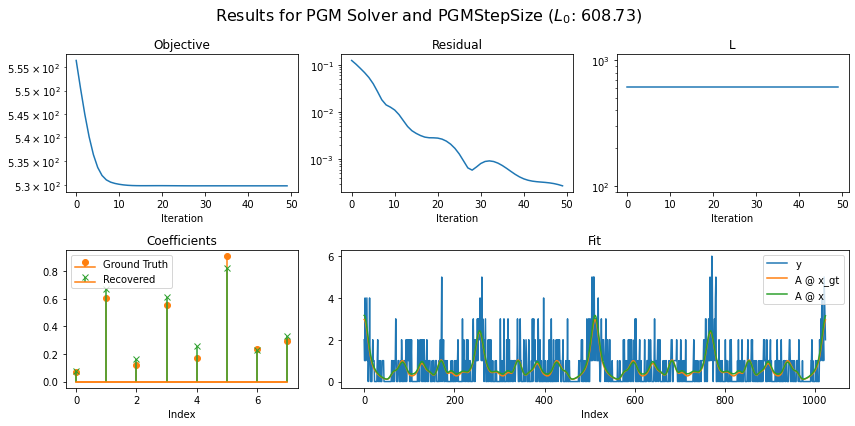

In [6]:
L0 = snp.linalg.norm(D, 2) ** 2  # initial reciprocal of gradient descent step size
str_L0 = "(Estimation based on norm of Forward operator)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
)
str_ss = type(solver.step_size).__name__

print(f"Solving on {device_info()}\n")
print("============================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # Run the solver.
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)

Use BBStepSize object, set L0 with arbitary initial value and set up
AcceleratedPGM solver object. Run the solver and plot the
recontructed signal and convergence statistics.

Running solver with step size of class:  BBStepSize
L0 (Arbitrary Initialization):  90.0 



Iter  Time      Objective  L         Residual
---------------------------------------------
   0  1.10e+00  5.578e+02  9.000e+01  8.370e-01


  10  1.66e+00  5.299e+02  3.249e+02  3.300e-02


  20  1.92e+00  5.299e+02  2.538e+02  1.811e-03


  30  2.16e+00  5.299e+02  2.248e+02  6.546e-04


  40  2.41e+00  5.299e+02  2.427e+02  2.353e-04


  49  2.65e+00  5.299e+02  2.545e+02  8.012e-05


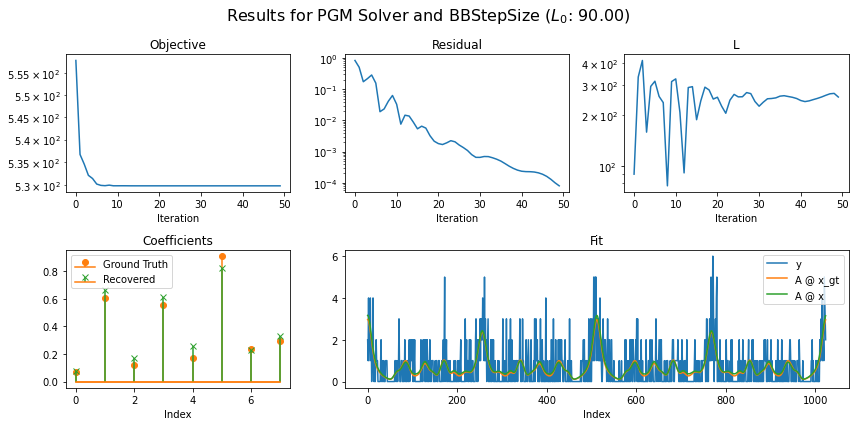

In [7]:
L0 = 90.0  # Initial reciprocal of gradient descent step size
str_L0 = "(Arbitrary Initialization)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    step_size=BBStepSize(),
)
str_ss = type(solver.step_size).__name__

print("===================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # Run the solver.
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)

Use AdaptiveBBStepSize object, set L0 with arbitary initial value and
set up AcceleratedPGM solver object. Run the solver and plot the
recontructed signal and convergence statistics.

Running solver with step size of class:  AdaptiveBBStepSize
L0 (Arbitrary Initialization):  90.0 

Iter  Time      Objective  L         Residual
---------------------------------------------
   0  8.96e-02  5.578e+02  9.000e+01  8.370e-01


  10  5.04e-01  5.299e+02  2.531e+02  3.182e-02


  20  8.00e-01  5.299e+02  2.766e+02  2.788e-03


  30  1.17e+00  5.299e+02  2.593e+02  6.632e-04


  40  1.55e+00  5.299e+02  2.508e+02  2.506e-04


  49  1.88e+00  5.299e+02  2.684e+02  1.076e-04


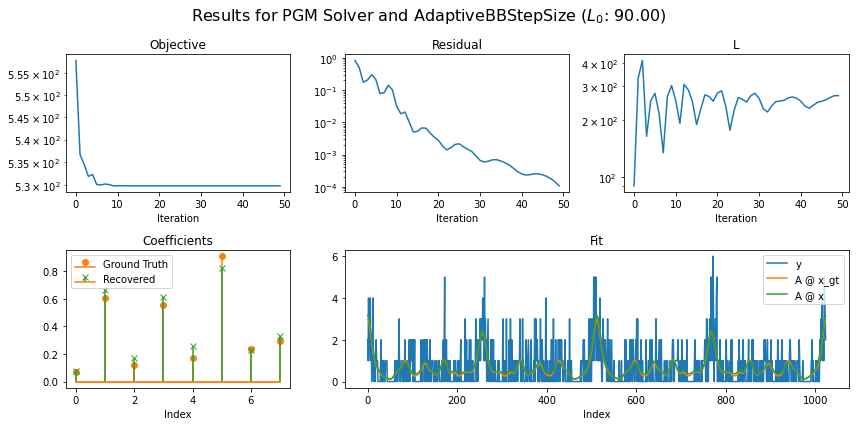

In [8]:
L0 = 90.0  # initial reciprocal of gradient descent step size
str_L0 = "(Arbitrary Initialization)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    step_size=AdaptiveBBStepSize(kappa=0.75),
)
str_ss = type(solver.step_size).__name__

print("===========================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # Run the solver.
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)

Use LineSearchStepSize object, set L0 with arbitary initial value and
set up AcceleratedPGM solver object. Run the solver and plot the
recontructed signal and convergence statistics.

Running solver with step size of class:  LineSearchStepSize
L0 (Arbitrary Initialization):  90.0 



Iter  Time      Objective  L         Residual
---------------------------------------------
   0  9.02e-01  5.435e+02  1.327e+02  5.678e-01


  10  2.28e+00  5.299e+02  3.281e+02  2.336e-03


  20  2.71e+00  5.299e+02  3.281e+02  6.099e-04


  30  3.11e+00  5.299e+02  3.314e+02  2.721e-04


  40  3.49e+00  5.299e+02  3.347e+02  1.315e-04


  49  3.84e+00  5.299e+02  3.448e+02  7.669e-05


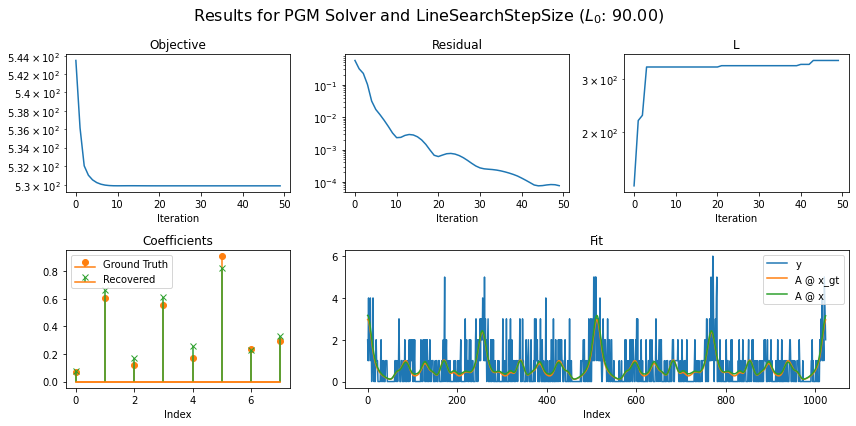

In [9]:
L0 = 90.0  # initial reciprocal of gradient descent step size
str_L0 = "(Arbitrary Initialization)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    step_size=LineSearchStepSize(gamma_u=1.01),
)
str_ss = type(solver.step_size).__name__

print("===========================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # Run the solver.
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)

Use RobustLineSearchStepSize object, set L0 with arbitary initial
value and set up AcceleratedPGM solver object. Run the solver and plot
the recontructed signal and convergence statistics.

Running solver with step size of class:  RobustLineSearchStepSize
L0 (Arbitrary Initialization):  90.0 



Iter  Time      Objective  L         Residual
---------------------------------------------
   0  2.75e-01  5.434e+02  1.620e+02  4.650e-01


  10  5.72e-01  5.299e+02  2.259e+02  1.806e-02


  20  8.52e-01  5.299e+02  3.151e+02  1.757e-03


  30  1.15e+00  5.299e+02  4.395e+02  5.640e-04


  40  1.46e+00  5.299e+02  1.226e+03  1.981e-04


  49  1.78e+00  5.299e+02  7.600e+03  5.092e-05


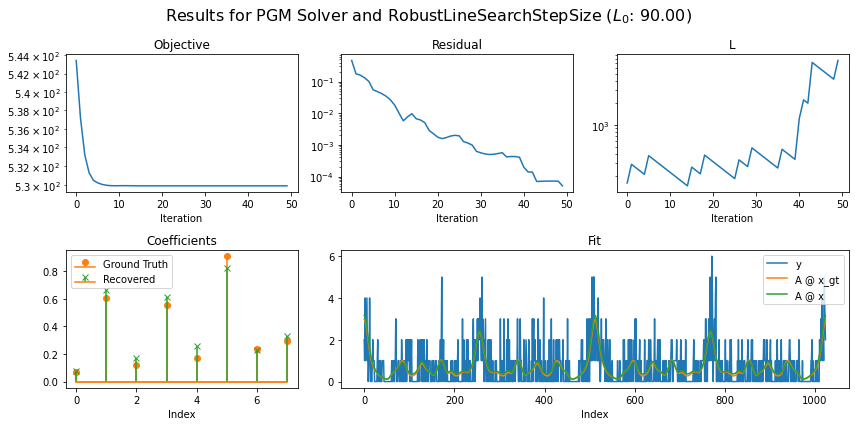

In [10]:
L0 = 90.0  # initial reciprocal of gradient descent step size
str_L0 = "(Arbitrary Initialization)"

solver = AcceleratedPGM(
    f=f,
    g=g,
    L0=L0,
    x0=x0,
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    step_size=RobustLineSearchStepSize(),
)
str_ss = type(solver.step_size).__name__

print("=================================================================")
print("Running solver with step size of class: ", str_ss)
print("L0 " + str_L0 + ": ", L0, "\n")

x = solver.solve()  # Run the solver.
hist = solver.itstat_object.history(transpose=True)
plot_results(hist, str_ss, L0, x, x_gt, A)